In [1]:
from models import *
from datetime import datetime
from random import random
from time import sleep
from functions import GetCurrentDate
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os

# Initiate parameters
start_date = "2019-12-30"  #"2018-12-31"  
end_date =  GetCurrentDate() #'2023-06-04'GetCurrentDate()

ticker = 'mrk'
period = "1wk" #1wk
shuffle = False
condition = False

# Sentiment types... APISentiment	VaderSentiment	CombinedVaderSentiment RobertaLargeSentiment #TwitterSentiment #ChatGPT_Sentiment
sentiment = True
sentiment_type = 'TwitterSentiment'
aggr_function = 'median'

#Setup windows
formation_window = 4
target_window = 1

#Split Ratios
split_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

if condition:
    print("--> Condition is ENABLED")
# EMA indicators
indicator1 = 4#5
indicator2 = 14#8
indicator3 = 32#21

#HPQ 1 2 3
#TSLA: 1 2 3
#MRK: 4 14 32

# training batches
batch_size_train = 6
batch_size_valid = 2

#Clear Folders
delete = True
export_excels = False

#__________________________________________________
# Do not change
api_key = '63'
api_key_gpt = "sk"

window_size = formation_window + 1

if sentiment == False:
    news_df = None
if sentiment_type == 'TwitterSentiment':
    twitter = True
else:
    twitter = False

if sentiment_type == 'ChatGPT_Sentiment':
    gpt_news_json_path = f"ChatGPT\{ticker}_chatgpt_news.json"

excel_reports = ".\Excel reports"
temp = f".\TempFiles\{ticker}"

#Delete folders
if delete == True:
    try:
        shutil.rmtree(excel_reports)
        shutil.rmtree(temp)
        
    except:
        pass
    # Create folder, if exist pass exception
    try:
        os.mkdir("Excel reports")
        os.mkdir(f"TempFiles\{ticker}")
    except:
        pass

# Print stuffs
print("\nTensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("\nwindow size: ", window_size)
print("formation_window: ", formation_window)
print("target_window: ", target_window)
print("chart period: ", period)


End Date:  2023-06-25

Tensorflow version:  2.9.1
Numpy version:  1.23.1

window size:  5
formation_window:  4
target_window:  1
chart period:  1wk


In [2]:
if sentiment == True:

    from sentiment import GetNews

    GetNewsAPI = GetNews()

    GetNewsAPI.fit(ticker=ticker, start_date=start_date, end_date=end_date,
                   n_news=1000, token=api_key, offset=0, export_excel=True, twitter=twitter,temp_folder=temp)
    news_df = GetNewsAPI.transform()

    # if sentiment_type == 'ChatGPT_Sentiment':

    #     from chatgpt import GetTitles, ChatGPTAnalysis

    #     print("ChatGPT Sentiment: True")

    #     titles_evaluate, news_df, json_exists,loaded_data  = GetTitles(news_df,gpt_news_json_path,ticker)
        
    #     news_df, c, titles_evaluate,a,b= ChatGPTAnalysis(api_key_gpt,titles_evaluate,news_df,json_exists,loaded_data,gpt_news_json_path)

news_df

d:\MachineLearning\DataScience\VSCode\04_StockPrediction\04_stockprediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------> GetNews completed



,Date,TwitterSentiment
0,2023-03-14,0.2164
1,2023-03-13,0.0709
2,2023-03-12,0.1398
3,2023-03-11,0.0332
4,2023-03-10,0.1048
...,...,...
416,2021-12-25,0.3981
417,2021-12-24,0.2592
418,2021-12-23,0.1089
419,2021-12-22,0.0763


In [3]:
if sentiment_type == 'ChatGPT_Sentiment':

        from chatgpt import GetTitles, ChatGPTAnalysis

        print("ChatGPT Sentiment: True")

        titles_evaluate, news_df, json_exists,loaded_data  = GetTitles(news_df,gpt_news_json_path,ticker)
        
        news_df, c, titles_evaluate,a,b= ChatGPTAnalysis(api_key_gpt,titles_evaluate,news_df,json_exists,loaded_data,gpt_news_json_path)

In [4]:
from transformers_preprocess import PullData

GetData = PullData()

print("ticker: ",ticker)
print("condition: ",condition)

GetData.fit(ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            interval=period,  
            progress=False,
            condition=condition,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=indicator1,
            timeperiod2=indicator2,
            timeperiod3=indicator3,
            export_excel=export_excels,
            excel_path=excel_reports,
            listed_conditions=None,
            sentiment=sentiment,
            sentiment_type=sentiment_type, 
            news_df=news_df,
            chart_period=period,
            sentiment_aggr=aggr_function,
            )

data_prep = GetData.transform()

# Validation
if window_size != (formation_window + 1):
    raise Exception(
        f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")

df = data_prep[data_prep['Date']!= "Month"].copy()

# Function to check if date is Monday
def is_monday(date):
    return date.weekday() == 0
# Loop through first 5 rows and check if the date is Monday
for index, row in df.head(10).iterrows():
    date_obj = row['Date'].date()

    if not is_monday(date_obj):
        raise Exception(f"Error: {date_obj} is not Monday.")
    
# IMPORTANT!!!!!!!!!!!!!!!!!!!!!!!!
        
# When getting data via yahoo finance API, with current date, there is distorted last formation, 
# when pulling weekly data, as target, it takes Friday's candle and distorts test set
# therefore we must remove last window.
data_prep = data_prep[:-window_size]
data_prep.tail()

ticker:  mrk
condition:  False
initial shape:  (193, 6)


,Date,Open,High,Low,Close,EMA4,EMA14,EMA32,TwitterSentiment,trades
176,2023-05-15 00:00:00,117.139999,117.739998,113.330002,115.489998,115.863461,112.386152,107.293403,0.0,177
177,2023-05-22 00:00:00,115.480003,117.080002,110.650002,111.070000,113.946076,112.210665,107.522287,0.0,177
178,2023-05-29 00:00:00,110.129997,112.730003,108.470001,112.519997,113.375644,112.251909,107.825179,0.0,177
179,2023-06-05 00:00:00,113.000000,114.480003,106.870003,110.709999,112.309386,112.046321,108.000016,0.0,177
0,Month,110.190002,110.989998,108.050003,109.320000,113.946076,112.210665,107.522287,0.0,177


In [5]:
#NEW CODE______________________
#If shuffle true, get test set that will not be shuffled for evaluation, we will shuffle only train and evaluation set
print("shuffle: ",shuffle)

if shuffle == True:
    from transformers_preprocess import NormalizeData

    NormalizeData = NormalizeData()

    NormalizeData.fit(window_size=window_size, shuffle=False, debug=False,
                    export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

    df_ = data_prep.copy()
    ttl_windows = len(df_)/window_size
    testsubset = round(ttl_windows*test_ratio, 0)

    xtest_split = testsubset * window_size
    test_split = int(xtest_split)

    print("DF Shape: ", df_.shape)
    print("test_split split: ", test_split)
    print("Shuffle is: ",shuffle)
        
    x_test_new = df_[-test_split:]

    data_prep = data_prep[:-test_split]
    print("revised data_prep shape",data_prep.shape)
    test_trade_start = int(x_test_new.trades.head(1))

    unshuffled_test, Dates_unshuffled_test = NormalizeData.transform(x_test_new)
#data_normalized_test.tail(10)


shuffle:  False


In [6]:
####################################################################

from transformers_preprocess import NormalizeData

if shuffle == False:
    
    NormalizeData = NormalizeData()

    NormalizeData.fit(window_size=window_size, shuffle=shuffle, debug=False,
                        export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

    data_normalized, Dates = NormalizeData.transform(data_prep)
else:
    NormalizeData = NormalizeData()

    NormalizeData.fit(window_size=window_size, shuffle=shuffle, debug=False,
                        export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

    data_normalized, Dates = NormalizeData.transform(data_prep) 
#data_normalized.head(8)
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast
data_prep


Dataframe shape:  (885, 10)
Number of formations:  177


--------> NormalizeData completed



,Date,Open,High,Low,Close,EMA4,EMA14,EMA32,TwitterSentiment,trades
0,2019-12-30 00:00:00,87.337784,87.919846,86.230919,87.070610,87.070610,87.070610,87.070610,0.0,1
1,2020-01-06 00:00:00,87.051529,87.538170,84.360687,85.429390,86.414122,86.851781,86.971142,0.0,1
2,2020-01-13 00:00:00,85.419846,87.843513,84.799622,86.803436,86.569848,86.845335,86.960978,0.0,1
3,2020-01-20 00:00:00,86.564888,86.803436,81.660301,82.041985,84.758702,86.204888,86.662857,0.0,1
0,Month,81.202293,84.122139,80.830154,81.526718,86.414122,86.851781,86.971142,0.0,1
...,...,...,...,...,...,...,...,...,...,...
176,2023-05-15 00:00:00,117.139999,117.739998,113.330002,115.489998,115.863461,112.386152,107.293403,0.0,177
177,2023-05-22 00:00:00,115.480003,117.080002,110.650002,111.070000,113.946076,112.210665,107.522287,0.0,177
178,2023-05-29 00:00:00,110.129997,112.730003,108.470001,112.519997,113.375644,112.251909,107.825179,0.0,177
179,2023-06-05 00:00:00,113.000000,114.480003,106.870003,110.709999,112.309386,112.046321,108.000016,0.0,177


In [7]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=export_excels, 
              excel_path=excel_reports, sentiment=sentiment,validation_set=validation_ratio, 
              test_set=test_ratio,shuffle=shuffle)

x_train, x_valid, x_test, x_train_x, x_valid_x, x_test_x, _ = SplitData.transform(data_normalized)


#NEW CODE______________________
print("Shuffle is ",shuffle)
if shuffle==True:
    unshuffled_test_extremes = unshuffled_test.iloc[:,-2:]
    unshuffled_test_df = unshuffled_test.iloc[:,:-2]
    print("test windows: ",unshuffled_test_df.shape[0]/window_size)
else:
    #if shuffle false, get 1st trade on test dataset for docker script
    test_trades = len(x_test)/window_size
    ttl_windows = len(data_prep)/window_size
    test_trade_start = int(ttl_windows-test_trades)
    print("Test trade starting at: ", test_trade_start)

Data_prep Shape:  (885, 10)
train_split split:  620
validation split:  135
test split:  135

Split train ratio: 70 %
Split validation ratio: 15 %
Split test ratio: 15 %

train period: 2019-12-30 - 2022-05-23
valid period: 2022-05-09 - 2022-11-28
test period: 2022-11-14 - 2023-06-05

Total Windows:  177.0
x_train windows:  123.0
x_valid windows:  27.0
x_test windows:  27.0
--------> SplitData completed

Shuffle is  False
Test trade starting at:  150


In [8]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed



In [9]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels_valid = GetTensoredValidDataset.transform(x_valid)

#NEW CODE______________________
#when shuffle false, x_test dataframe is unshuffled from default
print("shuffle is: ", shuffle)

if shuffle==False:
    x_test_tensors, labels = GetTensoredValidDataset.transform(x_test)
else:
    x_test_tensors, labels = GetTensoredValidDataset.transform(unshuffled_test_df)
    x_test = unshuffled_test_df.copy()
    x_test_x = unshuffled_test_extremes.copy()
    Dates = Dates_unshuffled_test.copy()
    
# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed

shuffle is:  False
--------> GetTensoredDataset completed



<b>Model Training</b>

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

datetime_ = datetime.today().date()
number = int(random()*10000)
model_name_ = f'{ticker}_model_{datetime_}_{number}.h5'
model_name = f'{temp}/{model_name_}'

metric = 'val_loss'
early_stopping = EarlyStopping(
    monitor=metric, patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=0)

model_checkpoint = ModelCheckpoint(monitor=metric,
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 1000.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Bellow code is used to find the best model architecture, recommended to use cloud computing

In [11]:
# from testing import get_models,optimize
# from datetime import datetime
# start_time = datetime.now().strftime("%H:%M:%S")
# start = datetime.now()
# print("Training started at ",start_time)
# tf.random.set_seed(7788)
# np.random.seed(7788)

# # #Permutation testing
# # num_layers = 2
# # min, max = 2, 4
# # node_step_size = 2
# # node_options = list(range(min, max + 1, node_step_size))
# # two_layer_possibilities = [node_options, node_options]
# # layer_node_permutations  = list(itertools.product(*two_layer_possibilities))

# f_df = pd.DataFrame()

# for layer in range(5,6):
#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("\n------ > Layer: ",layer)
#     print("Layer loop started: ",progress_time)

#     all_models, names = get_models(num_layers=layer, min=2, max=4, node_step_size=2, features=x_train.shape[1])

#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("Models: ",len(all_models))
#     print("Models constructed: ",progress_time)
    
#     optimizing_df = optimize(models=all_models,X_train=x_train_tensors,X_valid=x_valid_tensors,X_test=x_valid,labels=labels_valid,epochs=1000,verbose=0,window_size=window_size,callbacks=callbacks,layer=layer,ticker=ticker,excel_path=tested_models)
# # optimizing_df
#     f_df = f_df.append(optimizing_df)
#     f_df.to_excel('test.xlsx')
# end_time = datetime.now().strftime("%H:%M:%S")
# end = datetime.now()
# print("\nTraining ended at ",end_time) 
# print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")

Get Model

In [12]:
from datetime import datetime
start_time = datetime.now().strftime("%H:%M:%S")
start = datetime.now()
print("Training started at ",start_time)

tf.random.set_seed(7788)
np.random.seed(7788)
features = x_train.shape[1]

print(f"Model training - {str.upper(ticker)} \n")

def general_model(features: int):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv1D(filters=1, kernel_size=10,
                               strides=1, padding="same",
                               activation=tf.nn.selu,
                               input_shape=[None, features]),

        tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(3, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
        tf.keras.layers.Dense(4, activation=tf.nn.selu),
        tf.keras.layers.Dense(3, activation=tf.nn.selu),
        tf.keras.layers.Dense(2, activation=tf.nn.selu),
        tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    return model

def bac_model(features: int):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv1D(filters=1, kernel_size=10,
                               strides=1, padding="same",
                               activation=tf.nn.selu,
                               input_shape=[None, features]),

        tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(3, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
        tf.keras.layers.Dense(4, activation=tf.nn.selu),
        tf.keras.layers.Dense(3, activation=tf.nn.selu),
        # tf.keras.layers.Dense(2, activation=tf.nn.selu),
        #         tf.keras.layers.Dense(2, activation=tf.nn.selu),
                                # tf.keras.layers.Dense(2, activation=tf.nn.selu),
                                # tf.keras.layers.Dense(2, activation=tf.nn.selu),
        tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    return model

model = general_model(features)
#model = hpq_model(features)
#model = hp_model(features)
#model = bac_model(features)

#TSLA: 0.0007 learning rate
#HPQL=: 0.0003 learning rate
#BACL = learning_rate = 0.0007
#MRK learning_rate = 0.0007
learning_rate = 0.0007

optimizer2 = tf.keras.optimizers.Adam(
            learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# optimizer5 = tf.keras.optimizers.Adagrad(
#     learning_rate=0.0006, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer2
              )

model.fit(x_train_tensors, epochs=1000, callbacks=[callbacks], validation_data=x_valid_tensors,verbose=1)


end_time = datetime.now().strftime("%H:%M:%S")
end = datetime.now()
print("\nTraining ended at ",end_time) 
print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")



Training started at  17:36:08
Model training - MRK 

Epoch 1/1000
21/21 [==============================] - 52s 714ms/step - loss: 0.2902 - val_loss: 0.1621 - lr: 7.0000e-04
Epoch 2/1000
21/21 [==============================] - 1s 28ms/step - loss: 0.0851 - val_loss: 0.0754 - lr: 7.0000e-04
Epoch 3/1000
21/21 [==============================] - 1s 33ms/step - loss: 0.0721 - val_loss: 0.0663 - lr: 7.0000e-04
Epoch 4/1000
21/21 [==============================] - 1s 28ms/step - loss: 0.0730 - val_loss: 0.0653 - lr: 7.0000e-04
Epoch 5/1000
21/21 [==============================] - 0s 24ms/step - loss: 0.0713 - val_loss: 0.0644 - lr: 7.0000e-04
Epoch 6/1000
21/21 [==============================] - 1s 28ms/step - loss: 0.0696 - val_loss: 0.0627 - lr: 7.0000e-04
Epoch 7/1000
21/21 [==============================] - 1s 32ms/step - loss: 0.0682 - val_loss: 0.0609 - lr: 7.0000e-04
Epoch 8/1000
21/21 [==============================] - 1s 25ms/step - loss: 0.0669 - val_loss: 0.0591 - lr: 7.0000e-04
E

In [13]:
from functions import model_forecast
import time

forecast = model_forecast(model, x_test, window_size=window_size, debug=False)

from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_test=x_test, x_test_x=x_test_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()

time.sleep(3) 

from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_test=x_test,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)

time.sleep(1) 

from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
print(f'Total timeframe: {start_date} - {end_date}\n')
print(f"Shuffle: {shuffle} \n")
GetModelPerformance = GetModelPerformance()

acceptance = 0
penalization = 1

#TSLA penalization 0.4
#HP penalisation: 0.5
#MRK penalisation: 1
#BAC penalisation: 1
entry_candle = 'Current Open'
GetModelPerformance.fit(acceptance=acceptance,
                        penalization=penalization,
                        entry_candle=entry_candle,#Current Open
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df = trades_df.sort_values('Datetime',ascending=True)

trades_df.tail(7)




27/27 [==============================] - 11s 17ms/step
--------> ReverseNormalization completed

--------> GetFinalDataframe

ticker: MRK

Total timeframe: 2019-12-30 - 2023-06-25

Shuffle: False 

Formations:  27
period: 2022-11-14 - 2023-06-05
Entry Candle:  Current Open

Total Trades:  11
Profit Trades:  9
Loss Trades:  2

Win Ratio: 82.0 %
Loss Ratio: 18 %

Trade nr with exact TP:  7
Ratio of exact TP: 63.64 %

Average profit per trade:  178

Gross profit:  1955
Gross loss:  -81

Net profit:  1874


,Open,High,Low,Close,EMA4,EMA14,EMA32,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
123,115.480003,117.080002,110.650002,111.070000,113.946076,112.210665,107.522287,nn,nn,0.0,2023-05-22,2.389999,10
124,110.129997,112.730003,108.470001,112.519997,116.112436,111.908638,106.764590,112.730003,112.953747,0.0,2023-05-23,2.389999,10
130,117.139999,117.739998,113.330002,115.489998,115.863461,112.386152,107.293403,nn,nn,0.0,2023-05-15,-0.870003,11
131,115.480003,117.080002,110.650002,111.070000,113.946076,112.210665,107.522287,nn,nn,0.0,2023-05-22,-0.870003,11
132,110.129997,112.730003,108.470001,112.519997,113.375644,112.251909,107.825179,nn,nn,0.0,2023-05-29,-0.870003,11
133,113.000000,114.480003,106.870003,110.709999,112.309386,112.046321,108.000016,nn,nn,0.0,2023-06-05,-0.870003,11
134,110.190002,110.989998,108.050003,109.320000,113.946076,112.210665,107.522287,110.989998,113.00361,0.0,2023-06-06,-0.870003,11


In [19]:
# #trades_df.tail(10)
# trades_df[trades_df['profit']==0]

In [14]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
df = trades_df.head(3)


Trade:  1
Window size:  5
Period: 2023-01-02 - 2023-01-23

Budget:  10000

Entry price:  105.57
Label (target):  107.44
Model prediction:  107.05
Market Change: 1.48 $
Profit: 140.19 $


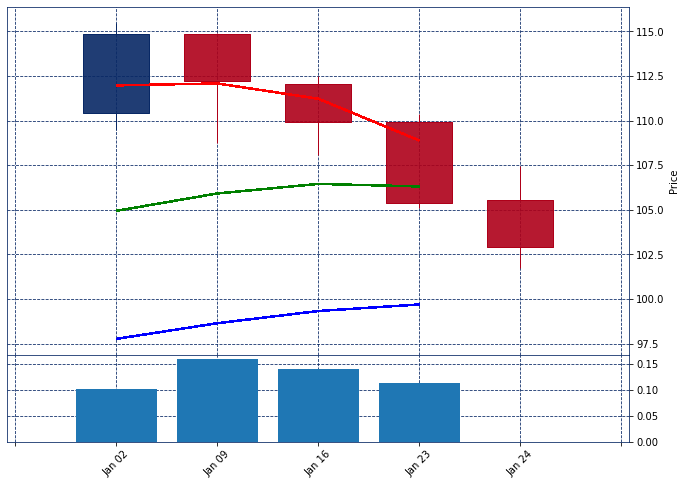

,Open,High,Low,Close,EMA4,EMA14,EMA32,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
35,110.410004,115.489998,109.489998,114.839996,111.976617,104.939982,97.759814,nn,nn,0.1013,2023-01-02,1.481609,1
36,114.879997,114.930000,108.750000,112.250000,112.085970,105.914651,98.638007,nn,nn,0.1597,2023-01-09,1.481609,1
37,112.029999,112.489998,108.099998,109.940002,111.227583,106.451364,99.322976,nn,nn,0.1402,2023-01-16,1.481609,1
38,109.930000,110.360001,105.110001,105.379997,108.888549,106.308516,99.690068,nn,nn,0.1138,2023-01-23,1.481609,1
39,105.570000,107.440002,101.750000,102.940002,112.085970,105.914651,98.638007,107.440002,107.051609,0.0000,2023-01-24,1.481609,1


In [15]:
#trade = 4
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,
budget=budget,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
trade += 1
df


In [16]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle=entry_candle,#entry_candle,#
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
#trades_df_final = trades_df_final.sort_values('Datetime', ascending=True)
trades_df_final.tail(10)

--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA4,EMA14,EMA32,labels,prediction,TwitterSentiment,Datetime,profit,trade,Entry,Performance
45,115.800003,119.650002,115.269997,117.680000,115.427393,111.103813,106.095209,nn,nn,0.0,2023-05-01,2.389999,10,nn,nn
46,117.080002,118.629997,116.379997,117.139999,116.112436,111.908638,106.764590,nn,nn,0.0,2023-05-08,2.389999,10,nn,nn
47,117.139999,117.739998,113.330002,115.489998,115.863461,112.386152,107.293403,nn,nn,0.0,2023-05-15,2.389999,10,nn,nn
48,115.480003,117.080002,110.650002,111.070000,113.946076,112.210665,107.522287,nn,nn,0.0,2023-05-22,2.389999,10,nn,nn
49,110.129997,112.730003,108.470001,112.519997,116.112436,111.908638,106.764590,112.730003,112.953747,0.0,2023-05-23,2.389999,10,110.129997,217.0
50,117.139999,117.739998,113.330002,115.489998,115.863461,112.386152,107.293403,nn,nn,0.0,2023-05-15,-0.870003,11,nn,nn
51,115.480003,117.080002,110.650002,111.070000,113.946076,112.210665,107.522287,nn,nn,0.0,2023-05-22,-0.870003,11,nn,nn
52,110.129997,112.730003,108.470001,112.519997,113.375644,112.251909,107.825179,nn,nn,0.0,2023-05-29,-0.870003,11,nn,nn
53,113.000000,114.480003,106.870003,110.709999,112.309386,112.046321,108.000016,nn,nn,0.0,2023-06-05,-0.870003,11,nn,nn
54,110.190002,110.989998,108.050003,109.320000,113.946076,112.210665,107.522287,110.989998,113.00361,0.0,2023-06-06,-0.870003,11,110.190002,-79.0


<b>Plot Chart With Labels and Predictions</b>

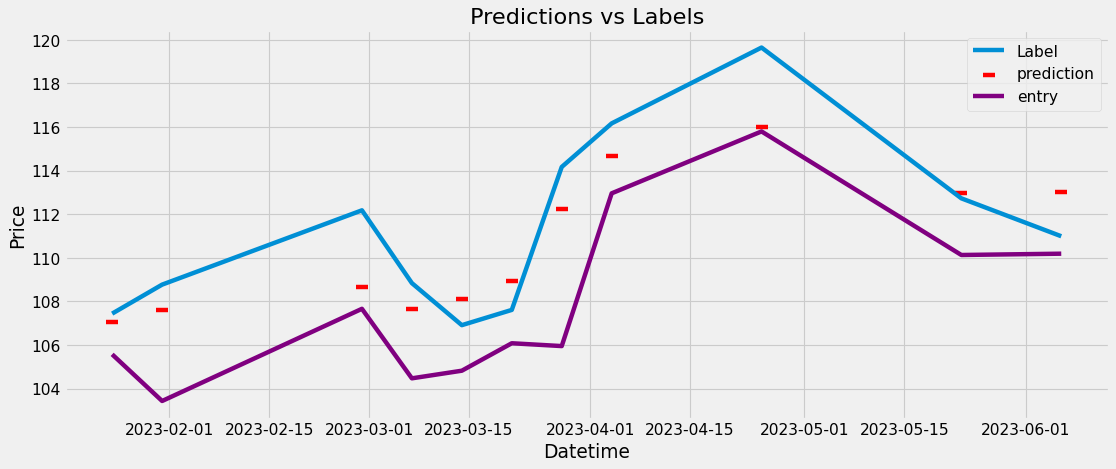

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(15, 6), dpi=80)

df_plot = trades_df_final[['Datetime','labels','prediction','Entry']]
df_plot = df_plot[df_plot.labels != 'nn']

x1 = df_plot['labels']
x2 = df_plot['prediction']
entry = df_plot['Entry']
y = df_plot['Datetime']

# plot lines
plt.plot(y, x1, label = "Label") #,s=200,marker='*'
plt.scatter(y, x2, label = "prediction",color='red', s=100,marker='_')
plt.plot(y, entry, label = "entry",color='purple')#,color='blue', s=100,marker=0
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Predictions vs Labels')
plt.legend()
plt.show()

<b>Export dataframe with all variables</b>

In [18]:

def ExportFile():
    today = datetime.today().date()
    if sentiment_type == 'ChatGPT_Sentiment':
        shutil.copy(gpt_news_json_path,temp)
        
    variables_dict = \
    {
    'model_name':[model_name_],
    'Date':[today],
    'ticker':[ticker],
    'period':[period],
    'api_key':[api_key],
    'sentiment':[sentiment],
    'sentiment_type':[sentiment_type],
    'aggr_function':[aggr_function],
    'formation_window':[formation_window],
    'target_window':[target_window],
    'split_ratio':[split_ratio],
    'test_ratio':[test_ratio],
    'validation_ratio':[validation_ratio],
    'condition':[condition],
    'indicator1':[indicator1],
    'indicator2':[indicator2],
    'indicator3':[indicator3],
    'window_size':[window_size],
    'formation_window':[formation_window],
    'twitter':[twitter],
    'start_date':[start_date],
    'end_date':[end_date],
    'batch_size_train':[batch_size_train],
    'batch_size_valid':[batch_size_valid],
    'shuffle':[shuffle],
    'entry_candle':[entry_candle],
    'excel_reports':[excel_reports],
    'gpt_json':[f"{ticker}_chatgpt_news.json"],
    'api_key_gpt':[api_key_gpt],
    'acceptance':[acceptance],
    'penalization':[penalization],
    'learning_rate':[learning_rate],
    'test_set_start':[test_trade_start]
    }

    x_test.to_csv(f'{temp}/{ticker}_test_data.csv')
    x_test_x.to_csv(f'{temp}/{ticker}_x_test_x.csv')
    test_start = len(Dates)-x_test.shape[0]
    Dates_test = Dates[test_start:]
    Dates_test.to_csv(f'{temp}/{ticker}_dates_test.csv')
    Dates.to_csv(f'{temp}/{ticker}_Dates.csv')
    df = pd.DataFrame(variables_dict).transpose()
    df.to_csv(f'{temp}/variables_df.csv')
    return df

df = ExportFile()
#df


In [22]:
from final_evaluation import MakeSinglePrediction


MakeSinglePrediction = MakeSinglePrediction()

print('penalization: ',penalization)
print('acceptance: ',acceptance)
fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date=start_date,
                        end_date="2023-06-25",
                        interval=period, #1wk
                        progress=False,
                        condition=condition,
                        timeperiod1=indicator1,
                        timeperiod2=indicator2,
                        timeperiod3=indicator3,
                        debug=False,
                        budget=10000,
                        penalization=penalization,
                        acceptance=acceptance,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type=sentiment_type,
                        sentiment_aggr=aggr_function)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.tail(formation_window)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

#final_trade_formation.tail()


penalization:  1
acceptance:  0


,Date,Open,High,Low,Close,EMA5,EMA8,EMA16,ChatGPT_Sentiment
1,2023-06-05,28.820000,29.650000,28.299999,29.270000,28.684067,28.757734,29.603395,0.561905
2,2023-06-12,29.299999,29.799999,28.690001,29.190001,28.852711,28.853793,29.554760,0.638095
3,2023-06-19,29.010000,29.040001,27.590000,27.750000,28.485141,28.608506,29.342435,0.586667



Ticker:  bac


1/1 [==============================] - 5s 5s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  27.75
Prediction:  27.15
Expected Market move:  -0.6
Expected Profit:  -216.01


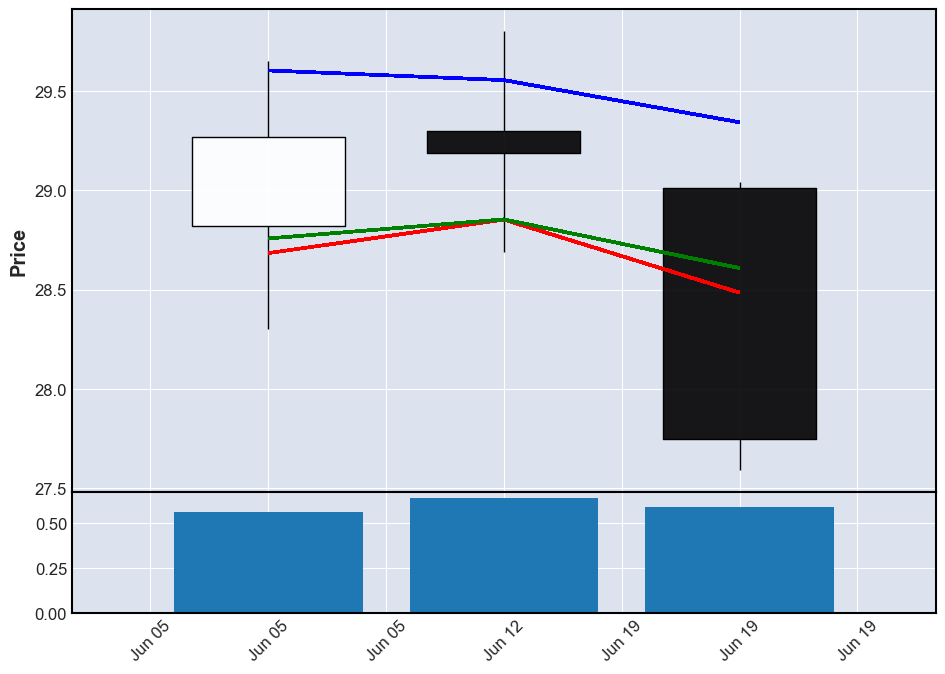

In [23]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart and sentiment
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
